# Deep Learning

Deep Learning is a subset of learning of Machine Learning which itself may be considered a subset of Statistics. In its essence Deep Learning aims to achieve matching between two statistical distributions through a powerful graphical structure: the *neural network*. The deep in Deep Learning refers to the number of layers in the graph, and this will become clearer as we proceed through the course, but has to come to more generally imply the size of the models being used.

This course will address several topics: we will cover the basic theory and history of neural networks; the primitive structures and functions found in a neural network; how to train a neural network; key methods of optimising training; different computational frameworks to work in; and several modern network topologies and the situations where they are best used. These topics will be addressed through the lecture notes and a series of workbooks which can be worked through:

* Introduction and Basics
* Hopfield Networks, and Multi-Layer Perceptrons
* Gradient descent, accelerated descent, and regularisation.
* Autoencoders
* Recurrent Neural Networks
* Convolutional Neural Networks
* Flux: Deep Learning in Julia
* Generative Adversial Networks
* Transformer Networks
* Graph Neural Networks and beyond...
* Variational Autoencoders
* PyTorch, Keras, and Tensor Flow: Deep Learning in Python


This notebook will cover the basics: the biology, some of the basic building blocks, some essential terms and concepts, and some history. By the end of the notebook we should understand what a neuron is and why collections of model neurons may be able to peform learning tasks. We will code our own learning neuron: the perceptron.

## Where are we going?

Before we start the course in earnest, we will give a simple example about what we are aiming for: how a neural network can look and what it might do. The cell block below contains code to load in a database and train a neural network to perform classification on unseen shark data *from scratch*. If you have a reasonably new computer (<10 years old) it's recommended that you run the function with the keyword ``train=true``. If you do not, don't worry, the code will load in the necessary pre-trained parameters and you can imagine that it was just trained very quickly.

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

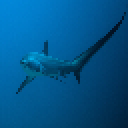
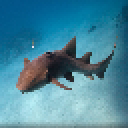
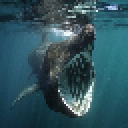
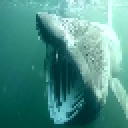
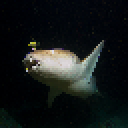
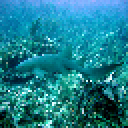
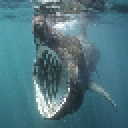
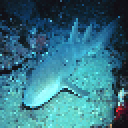
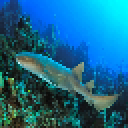
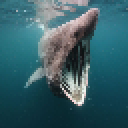
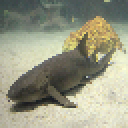
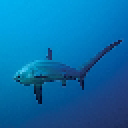
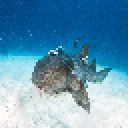
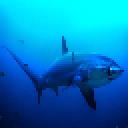
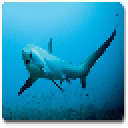
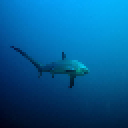
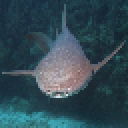
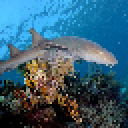
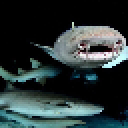
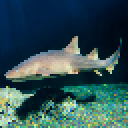
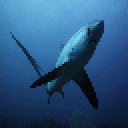
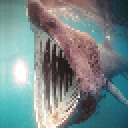
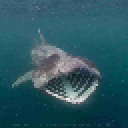
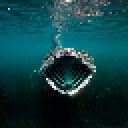
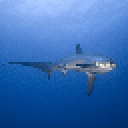
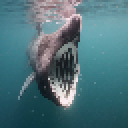
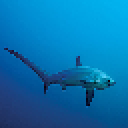
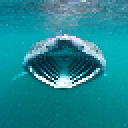
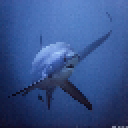
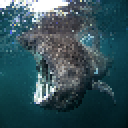
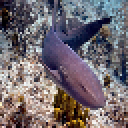
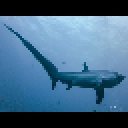
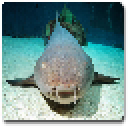
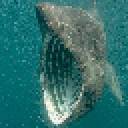
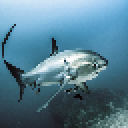
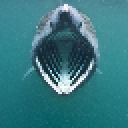
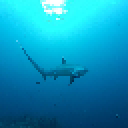
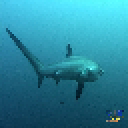
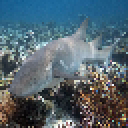
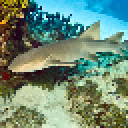
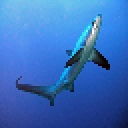
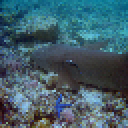
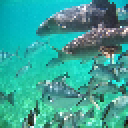
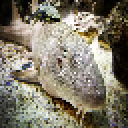
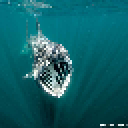
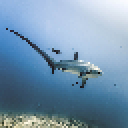
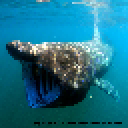
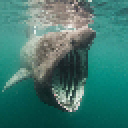
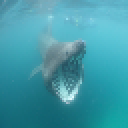
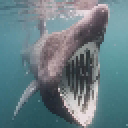
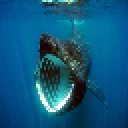
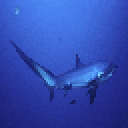
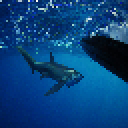
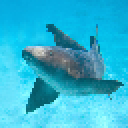
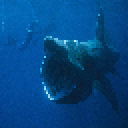
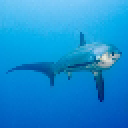
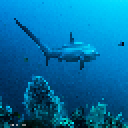
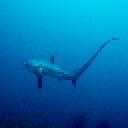
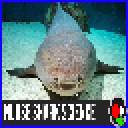
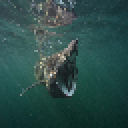

In [65]:
using JLD2, Images
data = JLD2.load("data/sharksimple/sharkdata.jld")
[data["images"]...]

Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


10-element Vector{Tuple{String, String}}:
 ("basking", "Prediction probability: 0.56591046")
 ("thresher", "Prediction probability: 0.5761163")
 ("thresher", "Prediction probability: 0.5761159")
 ("nurse", "Prediction probability: 0.5755257")
 ("thresher", "Prediction probability: 0.55769044")
 ("thresher", "Prediction probability: 0.5761169")
 ("thresher", "Prediction probability: 0.57611394")
 ("thresher", "Prediction probability: 0.5761164")
 ("nurse", "Prediction probability: 0.5761169")
 ("basking", "Prediction probability: 0.5759462")

10-element Vector{Any}:
 "basking"
 "thresher"
 "thresher"
 "nurse"
 "basking"
 "thresher"
 "thresher"
 "thresher"
 "nurse"
 "basking"

"Accuracy on test set: 90.0"

,,,,,,,,,

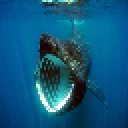
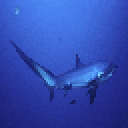
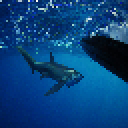
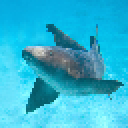
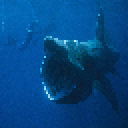
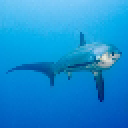
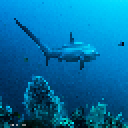
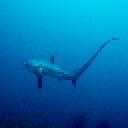
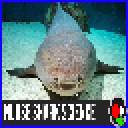
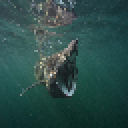

In [99]:
using Flux, Plots, ProgressMeter

function example_classifier(training_data, training_labels, nepochs, batch_size; train=false)
    categ = unique(training_labels)
    if train 
        convolutional = Chain(Flux.Conv((3,3), 3=>10, relu), Flux.MaxPool((2,2)), Flux.Conv((5,5), 10 => 5, relu), Flux.MaxPool((2,2)), Flux.Conv((10,10), 5 => 7, relu), Flux.flatten, Dense(112, length(categ), σ))
        p = Flux.params(convolutional)
        opt = Adam(0.005)
        loss(x, y) = Flux.logitcrossentropy(convolutional(x), Flux.onehotbatch(y, categ))
        d = Flux.DataLoader((training_data, training_labels), batchsize=batch_size) 
        @showprogress for t = 1:nepochs
            Flux.train!(loss, p, d, opt)
        end
    else
        "EhOAW"
    end
    
    function classifier(datum)
        probs = softmax(convolutional(datum))
        predict_prob, predictor = findmax(probs)
        return categ[predictor], "Prediction probability: $(predict_prob)"
    end
    
    return classifier
end

nepochs = 100
batch = 5
predict = example_classifier(data["train_data"], data["train_labels"], nepochs, batch; train=true)
predictions = predict.([data["test_data"][:,:,:,i:i] for i in 1:size(data["test_data"])[end]])
prediction_labels = data["test_labels"]
accuracy = sum([predictions[i][1] == prediction_labels[i] for i in 1:length(predictions)])/length(predictions)
display(predictions)
display(prediction_labels)
display("Accuracy on test set: $(accuracy * 100)")
[data["images"][end-length(data["test_labels"])+1:end]...]

This simple example demonstrates the power of Deep Learning. It took only a few seconds to train on very little data and yet it was able to perform a useful classification of sharks with 90% accuracy. This is far better than I would have been able to do and I have learnt a little about sharks. Whats more, "the meat" of the code is under 10 lines long!

## Biology

Deep Learning is an offshoot of Theoretical Neuroscience: a field dedicated to modelling and explaining brain related phenomena. Its fundamental units, neurons, and fundamental topographic structure, networks, come together to form the principal tool in the deep learning playbook: neural networks. The etymology of the words suggest a relationship to physical structures found in the brain and this is no accident. Deep Learning has borrowed heavily from insights generated by explanations of experiments performed on the brain.

### Neurons

For many, the neuron is the fundamental brain unit: an analogy might be to the atom in chemistry. This is a rather simplistic view that is largely wrong, but it is nevertheless a useful starting point to begin developing a mental model of how the brain may work. We will present a somewhat simplified view of neurons to begin with.

At its most primitive level a neuron is nothing more than a specialised *cell* that specialises in its ability to develop long-range connections and communicate with other cells. It can be described with a few fundamental structures: the soma (cell body), the axon, and dendrites. These three structures work together to generate and communicate signalling patterns in the form of events called *action potentials* or *spikes*. 

An action potential is a wave of change in the membrane voltage of a cell. When a cells membrane voltage releases a certain level it opens gated ionic channels which cause a rapid increase in the potential up until a peak where it decays and enters a refractory period; see [Image x]. This wave of voltage modulates the voltage in the membrane patch directly next to it which allows the action potential to be *transmitted* from the soma down the axon and to another cell. The axon terminates at a location called the *synapse* which bridges the axon of one cell with the dendrites of another cell. When the action potential reaches the synapses it triggers a release of vesicles known as *neurotransmitters* which can modulate the potential at the corresponding dendrite. This can be up-modulation or excitatory causing the neighbouring cell to be more likely to fire, or down modulation or *inhibitory* causing the neighbouring cell to be less likely to fire. Neurons are often referred to as excitatory/inhibitory for this reason. Therefore, in tandem these three structures work (in conjunction with other electrical inputs such as stimulus from the sensory organs) to modulate spiking in themselves and other neurons. These patterns of spiking convey information and perform computation e.g. a high spiking rate in a muscular neuron might cause a muscle to contract.

Neurons are themselves categorised into specialised subdivisions. The beginning of this classification is often regarded as the beginning of modern neuroscience with Raman y Cajal producing a series of beautiful drawings of stained neurons. There are many different neuron types and neuronal classification is often hotly debated.

[Images of Neurones]


### Networks

Neurons connect to each other through their dendrites and in doing so they create a network. A network is best thought of as a graph where nodes (neurones) are connected to each other through edges (dendrites). The entire brain forms a giant neural network of approximately $10^9$ neurones and $10^12$ synapses. This network is comprised of many sub-networks that often operate independently of each other. Some important networks (non-exhaustive) that have helped contribute to theoretical neuroscience and machine learning in significant ways include:

* Neocortex: inspired Marr's theory of the cortex.
* Hippocampus: instrumental for understanding memory models.
* Visual system: blueprint system for deep learning.
* Olfactory System: a playground for modern ideas.

# Mathematics and Computation

We are going to assume a fair amount of prior knowledge in this course. Nothing is too difficult but we will assume that everyone is familiar with the following concepts:

* Vectors, Matrices, and basic Linear Algebra
* Functions 
* Elementary Calculus
* Differential Equations
* Elementary Statistics

If these topics are unfamiliar then a good recommended reading is the first half of the excellent (and freely available) [Deep Learning](deeplearningbook.org) by Goodfellow et. al. (2016). It is actually a standard reference book for much of the following material and I would recommend all Deep Learning practioniers read through it at some point.
## Modelling

A model is simply a reduced explanation of some phenomena that generates insight about that phenomena. We can choose any format to outline our model in: words, equations, computational routines. Mathematical and computational models are desirable because they are *precise*. We shall very briefly touch on some foundational models of brain behaviour and some statistical modelling concepts.

### Neurone Models

The neural networks that we build are going to be networks constructed out of some type of representation of neurons. Any computational or mathematical representation is a model and it is therefore informative to understand some models of neural behaviour. This is an huge field as it amounts to understanding the most complex cells that we know of. We will touch on three broad classes of modelling neurones: biology, I-F, and Poisson.

#### Integrate and Fire Models

Integrate-and-fire models are the earliest biophysical models and typically work quite simplisticly. They are usually simple differential equations of membrane voltage augmented with a reset behaviour at some threshold $t$: if $v>t$ then $v = v_0$. The simplest model is the a statment of the law of capacitance:

$$ \frac{dv}{dt} = g_I I(t) $$

Thus, the neuron steps up its voltage everytime it increases its membrane voltage until it reaches the threshold and falls back down again. A neuron can be seen to be "integrating" the current spikes arriving through its dendritic inputs. An augmented version of this is to assume that some ionic leakage occurs allowing the voltage to decay:

$$ \frac{dv}{dt} = -v + g_I I(t) $$

This gives the neuron a memory of sorts and forces it to decay to a baseline both before and after spiking. This type of model is referred to as the *leaky integrate-and-fire* and is the most typical integrate-and-fire model employed.
#### Biophysical Models

These classes of models aim to be more accurate in-line with measurable biological processes. The seminal model was created by Hodgkin and Huxley in their analysis of the giant squid axon (the largest axon in the squid, not the axon of the giant squid). They proposed that the "leak" was the result of ionic channels with their own conductances and the concentrations of the ions in these channels obeyed Nernst equations. They came up with the following system of differential equations.

$$ \frac{dv}{dt} = g_I I(t) - n^4 g_K(v-v_K) - m^3 h g_{Na}(v-v_{Na}) - g_L(v-V_L)$$
$$ \frac{dn}{dt} = \alpha_n(v) (1-n)v - \beta_n n $$
$$ \frac{dm}{dt} = \alpha_m(v) (1-m)v - \beta_m m $$
$$ \frac{dh}{dt} = \alpha_h(v) (1-h)v - \beta_h h $$.

These four equations have a good grounding in physics: they are a statement of the law of conductance and concentration laws. The conductances correspond to potassium channels (K), sodium channels (Na) and a generic leak channel (L). They also provide a remarkably good fit to the data and are able to reproduce the spiking phenomema of a neuron without the need for thresholding as well as predict actual membrane voltages. They are therefore very useful in the biological domain.

This accuracy is not cheap. They are highly non-linear and require quite a lot of computation to be numerically stable. Therefore, they are typically examined in the context of real biological data but they are rarely used when only a proxy of a neuron is required. They are also naturally extensible, with the ability to incorporate ionic flows in an abritrary amount of channels and serve as a natural conductance and signalling model (e.g. calcium) in *all* cells, not just neurons.

#### Hybrid Models

Hybrid models aim to achieve the computational efficiency of the integrate-and-fire model with varying degrees of biological accuracy found in the Hogdkin-Huxley model. They are usually composed of a voltage variable ($v$) and a refractory variable ($u$) which stands in for the net effect of ionic flows. They typically, but not always, involve a reset threshold. The Morris-Lecar model was instrumental in understanding some of the mathematical properties of neurons. The Izhikevich model is perhaps the most successful model at reproducing biological dat in an integrate-and-fire framework.

#### Poisson Models
The Poisson neuron model is extremely simple. It assumes that the essential behaviour of a neuron is the timing of the spikes it releases and it assumes that a neuron will be governed by a spiking rate at time $t$ given by $r(t)$. Then, the model is a probabilistic model:

$$ S \sim \text{Pois}(r(t)) $$.

To generate spikes we sample randomly from this distribution. This amounts to dividing an interval of time $T$ into small chunks $dt$ and then drawing random numbers. The probability of a spike is $r(t)dt$ which when integrated out over the entire interval will give the expected number of spikes. This is *extremely* cheap especially compared to biophysical models and it is a remarkably good approximation with several studies examining the statistical validity of these basic assumptions. 
#### Activation functions
Given the periodic nature of a constant stimulus neurone and the accuracy of the Poisson model we might like to try and unify the biology with the spiking model. This leads us to the notion of an activation function which ties the membrane voltage to the spiking rate. The activation function can be equivalently described as the probability a neuron will spike in any given time interval or the fraction of the maximum firing rate a neuron can attain, for a given membrane voltage. Activation functions of almost all neurons take the form of a logisitic function (s-curve, sigmoid, etc.).

Several classes of activation functions have been proposed for different purposes. The sigmoid is the most common and is the solution to the differential equation $ \partial_x \sigma(x) = (1 - \sigma(x))\sigma(x)$. The `tanh` hyperbolic tan function is a rescaling of the sigmoid with an anti-symmetry at the origin. The `relu` or ramp function is given by $f(x) = x \Theta(x)$ where $\Theta$ is the Heaviside function and incorporates the idea that below a certain value a neuron is "inactive" and it ramps up after that value. It is also very cheap to compute and captures much of the essential behaviour of a biological activation function. The $\Theta$ function itself is an activation function and encapsulates the notion that a neuron is either "ON" or "OFF". In summation:

* Sigmoid
* Tanh
* Ramp 
* Heaviside Theta

### Network Models
A network model is a graph equipped with a dynamical model. A graph is a collection of nodes and edges which indicate which node is connected to which. The edges are typically weighted to indicate their importance. In our context this might be taken to mean the number of dendrites which attach to a particular node. Each node $i$ has a dynamic variable dependent on internal dynamics and contributions from its connections:

$$ \frac{du_i}{dt} = f_i(u_i) + \sum_k g_i(W_{ik}, u_k) $$

A network model simply involves specifying the network, and the functions that dicate the dynamics and then solving the coupled dynamical system.
#### Field Theory
A very brief aside; just as we can take a continuous limit of discrete spiking processes, we can also take continuous limits of network models. When we do this we arrive at neural field theories. These are typically more useful for mathematical proofs than they are for computation because implementing them on discrete hardware typically reduces them to a network model anyway. Nevertheless, they have produced some beautiful insights about the collective behaviour of neural populations.

### Statistical Models
Statistical models typically deal with the prediction of a random number. They are therefore ideal for data that has been measured in the real world with noise (or sufficiently complex processes that can be treated as such). Almost all deterministic models can be made into a statistical model by assuming the data and the parameters that define them are distributed according to some random distribution.

At its core a stastical model is composed of regressors (the indepedent variable) and observations (the depedent variable). The regressors are distributed under some distribution $ x \sim D$ and the model is a function of samples of this distribution: $y = f(x)$. This can be augmented by saying that the observation is a function of the regressor and some additive noise. The most common model is the linear model which relates a regressor vector $X_n$ to an observable vector $Y_m$ through a design matrix $W_{mn}$:

$$ Y_m = \sum_n W_{mn} X_n $$

The design matrix usually includes a constant variable as its first row (column). Sometimes these are seperated out and referred to as the bias (b). A large part of statistics involves learning the coefficients of a given model through linear regression. This can be called training the weights and biases.

The two predominant frameworks for dealing with estimation of these distributions (and more accurately, the parameters of these distributions) are Bayesian Statistics and Frequentist Statistics. We will not go into the details here but the Bayesian framework lends itself well to thinking about problems in Deep Learning. Detailed knowledge is not required for this course: it is sufficient to understand that a set of independent regressors from one distribution may be transformed into a sample of observables from another distribution through a model. The primary goal of statistical modelling is to explain the observable data through a model and to use available data to train the parameters of the model.

### Classification, Regression, and Generation
There are three big "tasks" that a statistical model can perform. This is quite a simplistic view, but it will serve us well for now. These are classification, regression, and generation. They are all intimately related: they use the underlying model transformation. Classification is actually just regression on a categorical distribution, but this is not how most people think of it.

#### Classification
A classification task involves taking an observable that is drawn from some distribution and classifying it. For example the distribution might be "animals you have seen today" and the classification distribution is "animals that you know". A statistical model might be able to relate these two variables and transform the observation of an an animal into probabilities of known animals. Think about how this might vary if you are on safari.

#### Regression
A regression task involves making a prediction of an observable given a regressor. You might have a model of cell damage given a specific volume of radiation that the cell has received. For an unknown cell that has received a dosage of "n units" we make a prediction of cell damage by regression on the model: damage = f(n units).

#### Generation
A model that maps a regressor space to an observable space can be used to generate data in the observable space by simply modelling a random sample in the regressor space. This comes from the assumption that $Y \sim f(X)$. This is a useful fact which allows for many useful and beautiful tools to be generated. Suppose we want to relate the space of sentences and images. After we generate a model on a dataset of sentence-image pairs we can query a random sentence (a sample in regressor space) and receive a brand new image. We can thus generate new images using a statistical model! 

## Perceptron

We now would like to unify our biology and our statistical modelling paradigms. We note that, in a simplisitic sense, a neurons firing rate output can be modelled with a logisitic function. It can therefore be thought of as performing a classification, or some form of logisitic regression. We also note that a neurons output is dependent on the sum of its weighted inputs that arrive through the dendrites and some internal resting state. We can call these dendritic weights the weights $W$ and the resting points the biases $b$. We can write this as a function:

$$ u_i = \sigma\left(\sum_jW_{ij} v_j + b_i \right) $$

with $\sigma$ being the activation function and $v_j$ being the input to the network. When the activation function is a simple thresholding function (i.e. 1 above the threshold and 0 otherwise) we refer to it as a *perceptron* and it is one of the earliest forms of neurally inspired machine learning models. We can draw an immediate analogy to our statistical model and say that the neuron is performing the role of a classifier: when the firing threshold is crossed the neuron is activated and we classify the input as a different type. By tuning the dendritic weights and the baseline rate we can do biological statistics. 

Assume that the data for the input $v_j$ is $d_i$. The weights are tuned according to a very simple rule:

$$W_{ij}(t+1) = W_{ij}(t) + r (u_i - d_i) v_j$$.

If you have done a course in linear regression you might immediately realise this as a gradient descent on the square of the errors i.e. we are minimising the mean squared error of the classification data. Alternatively, if you are familiar with biological learning you might understand this as a proxy of a expectation-reward scheme: when a neuron is presented with a divergent output to what is expected neurotransmitters are released which change the weights to move the output closer to what is expected. We can naturally extend this definition to a series of outputs $i \in 1:N$ and perform the classification in a higher dimensional decision space. These procedures extend analagously. 

We therefore can see that the neurone (or perceptron) provides a powerful classification or regresion scheme with a natural biological motivation. It unifies very well with our models of linear regressors and classifiers and can be understood through a well-studied statistical lense. Let's train a perceptron on a simple classification task that an early human might have had to learn:

In [56]:
using Plots
plotly()
domestic_class = ["🐈", "🐀", "🐔", "🐕"]
wild_class = ["🦥", "🐗", "🦊", "🦓", "🦘", "🦉", "🦄"]
domestic = [[0.740562, 0.74002, 1.15348, 0.773644], [0.32662, 0.835877,  1.04288,  1.04741]]
wild = [[1.17844, 1.98878, 1.19889,  1.92041,  2.10834,  1.55384,  1.07955], [1.60585,  1.96469,  1.68477,  1.40337,  1.21203,  1.3704,  1.0018]];
function np()
    p = plot(; xlim=(0,2.3), ylim=(0,2.3), title="Animals", ticks=false)
    for i in 1:length(domestic[1])
        annotate!(p, (domestic[1][i], domestic[2][i], text(domestic_class[i])))
    end

    for i in 1:length(wild[1])
        annotate!(p, (wild[1][i], wild[2][i], text(wild_class[i])))
    end
    return p
end
p = np()

We initialise our weights randomly and then use the learning rule to update them sequentially. We can visualise this as the perceptron learning through time.

In [58]:
global W = [1 1]
global b = -4
global r = 0.1
global thresh = 0.0

function train_epoch(domestic, wild, W, b, r, thresh)
    # class 1
    for i = 1:(length(domestic[1]) + length(wild[1]))
        if i <= length(domestic[1])
            datum = [domestic[1][i], domestic[2][i]]
            pred = W * datum .+ b
            err = (pred[1] > thresh)
        else
            datum = [wild[1][Int(i-length(domestic[1]))], wild[2][Int(i-length(domestic[1]))]]
            pred = W * datum .+ b
            err = -(pred[1] < thresh)
        end
        W = W .- r .* err .* datum'
        b = b .- r .* err 
    end
    
    return W, b
end

xs = []; ys = [];
for t = 1:100
    x = -20:0.01:20
    y = collect((-W[1] .* x .- b) ./ (W[2]))
    W, b = train_epoch(domestic, wild, W, b, r, thresh)
    p = np()
    plot!(p, x, y; label="Discrimator at time t = $(t)")
    push!(xs, [x])
    push!(ys, [y])
    display(p)
    IJulia.clear_output(true)
    sleep(0.1)
end